In [1]:
import pandas as pd
import re
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
df = pd.DataFrame()

In [3]:
# Using readline() 
file1 = open('simplez80-mobo.kicad_pcb', 'r') 
count = 0
line = file1.readline()
bad_chars = [';', ':', '!', "*"] 

while line: 
    line = file1.readline() 
  
    if "segment" in line:
        line = line.rstrip()
        line = re.sub("\)", "", line)
        #print(line)
        parse = line.split("(")
        
        for i in parse:
            if i.startswith("start"):
                coords = i.split(" ")
                startx=float(coords[1])
                starty=float(coords[2])
                
            if i.startswith("end"):
                coords = i.split(" ")
                endx=float(coords[1])
                endy=float(coords[2])
                
            if i.startswith("width"):
                coords = i.split(" ")
                width=float(coords[1])
                
            if i.startswith("layer"):
                coords = i.split(" ")
                pdrow = pd.DataFrame({"startx":startx,"starty":starty,"endx":endx,"endy":endy,"width":width,"layer":coords[1]}, index=[0]) 
                df = df.append(pdrow)
  
file1.close() 

In [4]:
pxmm = 50 ### 300DPI = 12pixels per mm

boardminx = min(min(df.startx),min(df.endx))-10
boardmaxx = max(max(df.startx),max(df.endx))+10

boardminy = min(min(df.starty),min(df.endy))-10
boardmaxy = max(max(df.starty),max(df.endy))+10

brd_width = int((boardmaxx-boardminx) * pxmm)
brd_height = int((boardmaxy-boardminy) * pxmm) 

print("Board:", brd_width,"x",brd_height, "pixels")

Board: 4629 x 5594 pixels


In [5]:
df['dsx'] = ((df.startx-boardminx)*pxmm).astype('int32', copy=False)
df['dex'] = ((df.endx-boardminx)*pxmm).astype('int32', copy=False)
df['dsy'] = ((df.starty-boardminy)*pxmm).astype('int32', copy=False)
df['dey'] = ((df.endy-boardminy)*pxmm).astype('int32', copy=False)
df['dwi'] = (df.width*pxmm).astype('int32', copy=False)


In [6]:
blank_image = np.zeros((brd_height,brd_width,3), np.uint8)

In [7]:
for index, row in df[df['layer']=='B.Cu'].iterrows():
    blank_image = cv2.line(blank_image, 
                           (row['dsx'],row['dsy']), 
                           (row['dex'],row['dey']), 
                           (255,255,255), 
                           row['dwi'])
cv2.imwrite('map.png',blank_image)


True

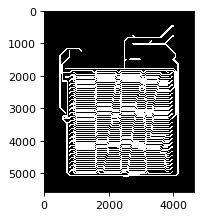

In [8]:
figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(blank_image)
plt.show()

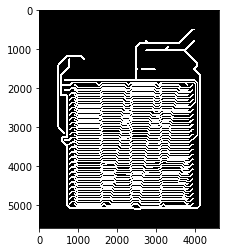

In [9]:
bw = np.dot(blank_image[...,:3], [0.2989, 0.5870, 0.1140])
(my,mx) = bw.shape

for i in range(my):
    bw[i,0]=255
    bw[i,mx-1]=255

for i in range(mx):
    bw[0,i]=255
    bw[my-1,i]=255
    
bw[my-1,]=255
bw[:,mx-1]=255

plt.imshow(bw, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()